In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

z=np.array([0.07,0.09,0.12,0.17,0.179,0.199,0.20,0.27,0.28,0.352,0.3802,0.4,0.4004,0.4247,0.4497,0.47,0.4783,0.48,0.593,0.68,0.781,0.875,0.88,0.90,1.037,1.3,1.363,1.43,1.53,1.75,1.965])
Hz=np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,87.1,92.8,89,80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
err=np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.2,12.9,50,9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])
c = 2.99792458e5
z_bao =  np.array([0.38,0.38,0.51,0.51,0.61,0.61,0.122,0.81,1.52,2.34,2.34])
Aobs_bao = np.array([1512.39,81.2087,1975.22,90.9029,2306.68,98.9647,539,10.75,3843,8.86,37.41])
C_mat = np.array([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778,0,0,0,0,0],
                  [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056,0,0,0,0,0],
                  [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013,0,0,0,0,0],
                  [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334,0,0,0,0,0],
                  [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327,0,0,0,0,0],
                  [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936,0,0,0,0,0],
                  [0,0,0,0,0,0,289,0,0,0,0],
                  [0,0,0,0,0,0,0,0.1849,0,0,0],
                  [0,0,0,0,0,0,0,0,21609,0,0],
                  [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                  [0,0,0,0,0,0,0,0,0,-0.183396,3.4596],
                 ])


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:41<00:00, 485.21it/s]


Parameter estimates:
H0: 66.80 +3.78/-3.88
Omega_M: 0.30 +0.14/-0.15
Omega_A: 0.60 +0.26/-0.33


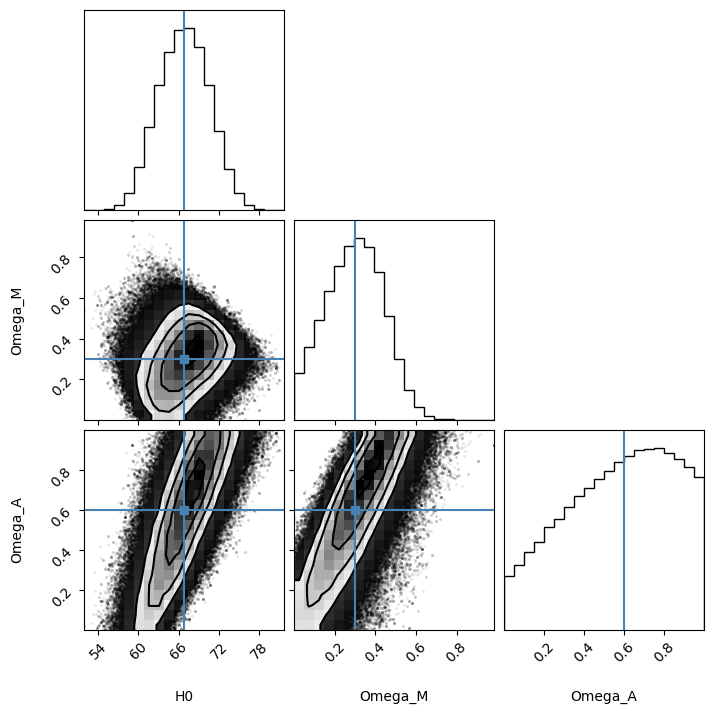

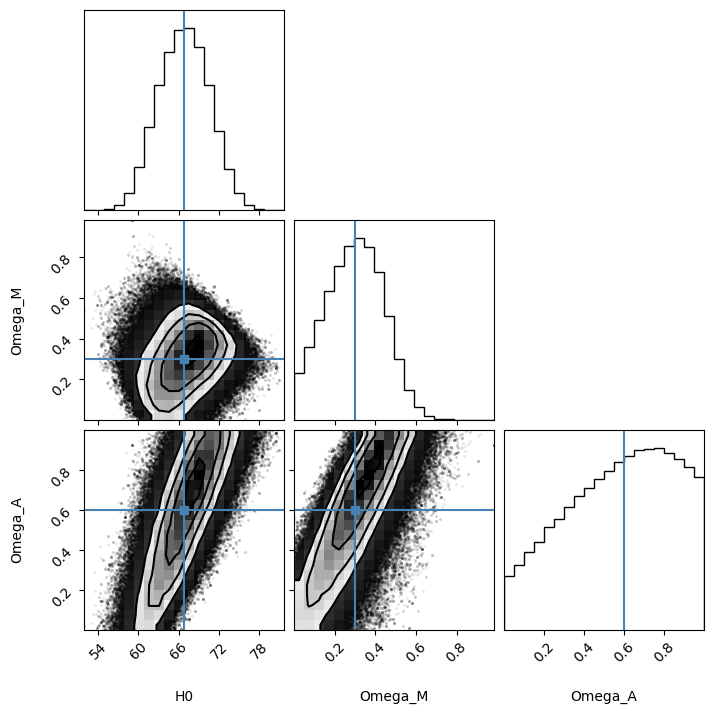

In [33]:
import numpy as np
import emcee
import corner

# Example data (replace with your actual data)
z_data = z
H_data = Hz
uncertainties = err

# Define the LCDM model and chi-squared function
def lcdm_model(params, z):
    H0, Omega_M , Omega_A= params
    return H0 * np.sqrt(Omega_M * (1 + z)**3 + (1 - Omega_M - Omega_A) * (1+z)**2 + Omega_A)

def chi_squared(params, z_data, H_data, uncertainties):
    model_predictions = lcdm_model(params, z_data)
    chi_sq = np.sum(((H_data - model_predictions) / uncertainties) ** 2)
    return chi_sq

# Define log likelihood function for emcee
def log_likelihood(params, z_data, H_data, uncertainties):
    chi_sq = chi_squared(params, z_data, H_data, uncertainties)
    return -0.5 * chi_sq

# Define log prior function for emcee
def log_prior(params):
    H0, Omega_M, Omega_A = params
    # Apply priors here if necessary
    if 50.0 < H0 < 100.0 and 0.0 < Omega_M < 1.0 and 0 < Omega_A < 1:
        return 0.0
    return -np.inf

# Define log probability function for emcee
def log_probability(params, z_data, H_data, uncertainties):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, z_data, H_data, uncertainties)

# Initial guess for parameters
initial_params = [70.0, 0.35, 0.76]

# Set up the emcee sampler
n_walkers = 32
n_dim = len(initial_params)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(z_data, H_data, uncertainties))

# Run the MCMC sampler
n_steps = 20000
sampler.run_mcmc(initial_params + 1e-4 * np.random.randn(n_walkers, n_dim), n_steps, progress=True)

# Get the samples from the MCMC chain
samples = sampler.get_chain(discard=100, flat=True)

# Calculate percentiles for uncertainties
percentiles = np.percentile(samples, [16, 50, 84], axis=0)

# Print and plot the results using corner plot
print("Parameter estimates:")
print("H0: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 0], percentiles[2, 0] - percentiles[1, 0], percentiles[1, 0] - percentiles[0, 0]))
print("Omega_M: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 1], percentiles[2, 1] - percentiles[1, 1], percentiles[1, 1] - percentiles[0, 1]))
print("Omega_A: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 2], percentiles[2, 2] - percentiles[1, 2], percentiles[1, 2] - percentiles[0, 2]))

# Plot corner plot
labels = ['H0', 'Omega_M', 'Omega_A']
corner.corner(samples, labels=labels, truths=percentiles[1, :])

In [34]:
def Lcdm_model(Ho, Omega_M, Omega_A,z):
    return Ho * np.sqrt(Omega_M * (1 + z)**3 + (1 - Omega_M - Omega_A) * (1+z)**2 + Omega_A)
def E(Ho, Omega_M,Omega_A,z):
    term_e = Omega_M*((1+z)**3) + (1 - Omega_M - Omega_A) * (1+z)**2 + Omega_A
    return np.sqrt(term_e)
def DH(Ho,Omega_M, Omega_A,z):
    return c/(Ho*E(Ho,Omega_M,Omega_A,z))
def f(z,Ho,Omega_M,Omega_A,):
    return c/(Ho*E(Ho, Omega_M,Omega_A,z))
def DC(Ho,Omega_M,Omega_A,z):
    val,er=quad(f,0,(z), args=(Ho,Omega_M,Omega_A,))
    return val
def DM(Ho,Omega_M,Omega_A,z):
    return DC(Ho,Omega_M,Omega_A,z)
def DV(Ho,Omega_M,Omega_A,z):
    return ((c/Ho)*(DM(Ho,Omega_M,Omega_A,z)**2)*(z/E(Ho,Omega_M,Omega_A,z)))**(1/3)
def DA(Ho,Omega_M,Omega_A,z):
    return DM(Ho,Omega_M,Omega_A,z)/(1+z)
def rs(Ho,Omega_M):
    h = (Ho/100)
    num = np.exp(-72.3 * ((0.0014 * h**2 + 0.0006)**2))
    den = ((0.02225) ** 0.12807) * (((Omega_M - 0.0014) * h**2) ** 0.25351)
    return 55.154*num/den

rs_fid = 147.78
Wb0_hsq = np.array([0.02225,0.02305,0.02229,0.02305])

def fu(Ho,Omega_M,Omega_A,z_bao):
    Ath_bao = np.zeros(11)
    D_m_range = [0,2,4]
    hub_range = [1,3,5]
    D_v_range = [6,8]
    for i in D_m_range:
        k =  z_bao[i]
        Ath_bao[i] = DM(Ho,Omega_M,Omega_A,k)*rs_fid/rs(Ho,Omega_M)
    for i in hub_range:
        k =  z_bao[i]    
        Ath_bao[i] = Ho*E(Ho,Omega_M,Omega_A,k)*rs(Ho,Omega_M)/rs_fid
    for i in D_v_range:
        k =  z_bao[i]
        Ath_bao[i] = DV(Ho,Omega_M,Omega_A,k)*rs_fid/rs(Ho,Omega_M)
    Ath_bao[7] = DA(Ho,Omega_M,Omega_A,z_bao[7])/(rs(Ho,Omega_M))
    Ath_bao[9] = DH(Ho,Omega_M,Omega_A,z_bao[9])/rs(Ho,Omega_M)
    Ath_bao[10] = DM(Ho,Omega_M,Omega_A,z_bao[10])/rs(Ho,Omega_M)
    return Ath_bao

In [35]:
def chi_new(para,z_bao,Aobs_bao,C_mat):
    Ho, Omega_M,Omega_A=para
    Ath_bao = fu(Ho,Omega_M,Omega_A,z_bao)
    p = Ath_bao - Aobs_bao
    C_inv = np.linalg.inv(C_mat)
    t1 = np.matmul(C_inv,p)
    return np.matmul(p.T, t1)
def chi_sq_LCDM_flat(para,z,Hz,err,z_bao,Aobs_bao,C_mat):
    Ho, Omega_M,Omega_A=para
    chi_squared=0
    for i in range(len(z)):
           chi_squared += ((Hz[i] - Lcdm_model(Ho,Omega_M,Omega_A,z[i])) / err[i]) ** 2
    return chi_squared + chi_new(para,z_bao,Aobs_bao,C_mat)

In [38]:
np.random.seed(99)
nll = lambda *args : chi_sq_LCDM_flat(*args)
H0_ini = 70
Wm0_ini = 0.35
WA0_ini=0.76
initial = np.array([H0_ini,Wm0_ini,WA0_ini])

soln = minimize(nll, initial, args=(z,Hz,err,z_bao,Aobs_bao,C_mat),bounds=[(0,np.inf),(0,1),(0,1)])
H0_opt_LCDM_flat, Wm0_opt_LCDM_flat, WA0_opt_LCDM_flat= soln.x
print(soln)
H0_opt_LCDM_flat, Wm0_opt_LCDM_flat,WA0_opt_LCDM_flat

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 20.22927775850811
        x: [ 6.713e+01  3.117e-01  6.436e-01]
      nit: 11
      jac: [-3.553e-07 -9.024e-05 -2.949e-05]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


(67.12574375187077, 0.3116697911550129, 0.6436453187717442)

In [39]:
def log_prior_LCDM_flat(opt):
    Ho, Omega_M,Omega_A = opt
    if 0.1 <= Omega_M <= 0.7 and 50 <= Ho <= 85 and 0.1<= Omega_A <= 0.7:
        return 0.0
    return -np.inf
def log_probability_LCDM_flat(opt,z,Hz,err,z_bao,Aobs_bao,C_mat):
    lp = log_prior_LCDM_flat(opt)
    if not np.isfinite(lp):
        return -np.inf
    return lp - 0.5*chi_sq_LCDM_flat(opt,z,Hz,err,z_bao,Aobs_bao,C_mat)
pos = soln.x + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_LCDM_flat, args = (z,Hz,err,z_bao,Aobs_bao,C_mat))
sampler.run_mcmc(pos, 2000, progress = True)

100%|██████████| 2000/2000 [08:55<00:00,  3.74it/s]


State([[68.02568167  0.32345168  0.64709022]
 [63.81118009  0.31264442  0.52772406]
 [64.61233742  0.35474767  0.46932266]
 [67.86342296  0.32740297  0.67227124]
 [66.8793424   0.33320251  0.56652325]
 [65.24264048  0.28547037  0.59372882]
 [66.365001    0.31626034  0.61218279]
 [62.03105394  0.30360575  0.50100554]
 [67.39564605  0.29212864  0.67069061]
 [67.37994784  0.31798688  0.6402842 ]
 [64.4920129   0.27717119  0.65967199]
 [65.85782398  0.32441814  0.56454687]
 [67.46029792  0.30231809  0.65949552]
 [62.81708951  0.28934776  0.55244497]
 [66.2764631   0.32802796  0.64788499]
 [67.03217136  0.33294849  0.61685259]
 [64.8499737   0.31591517  0.52950179]
 [67.34317473  0.29830978  0.63201422]
 [66.77960791  0.33942122  0.57267779]
 [70.35415506  0.31259958  0.69709924]
 [68.90505228  0.31610946  0.63303271]
 [68.44696873  0.32208306  0.66696481]
 [66.96935959  0.31398694  0.66309229]
 [66.02361077  0.30799564  0.62831841]
 [66.63155511  0.32877742  0.5857127 ]
 [66.12235002  0.31

In [40]:
tau_LCDM_non_flat = sampler.get_autocorr_time()
print(tau_LCDM_non_flat)

[34.80576675 34.96664211 35.02144595]


(400000, 3)


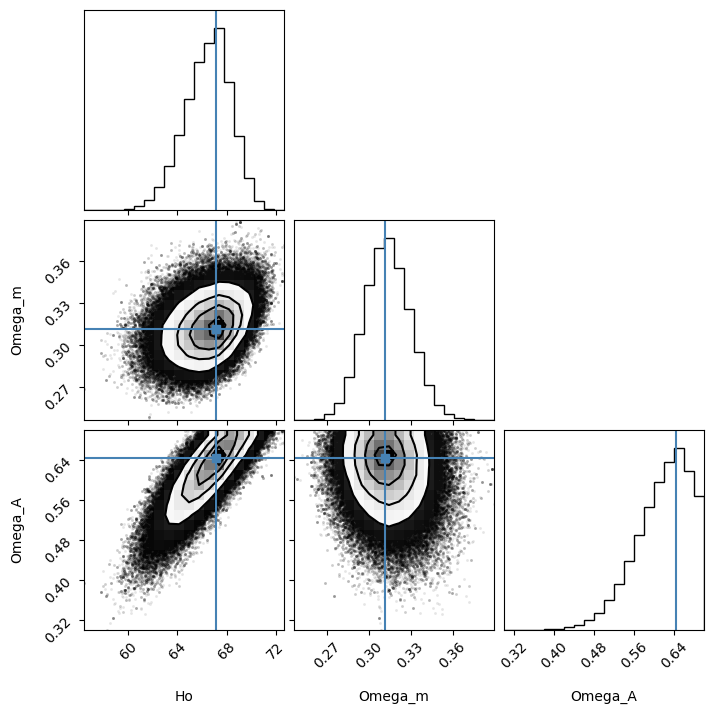

In [41]:
non_flat_samples = sampler.get_chain(flat=True)
print(non_flat_samples.shape)
labels = ["Ho", "Omega_m","Omega_A"]

fig = corner.corner(
    non_flat_samples, labels=labels, truths=[H0_opt_LCDM_flat, Wm0_opt_LCDM_flat,WA0_opt_LCDM_flat]
);

In [42]:
sampler.reset()
sampler.run_mcmc(pos,20000,progress= True)

100%|██████████| 20000/20000 [1:50:57<00:00,  3.00it/s]  


State([[64.0206988   0.30430941  0.53371508]
 [63.4291254   0.32927145  0.48019268]
 [69.13624305  0.31652886  0.68412173]
 [68.27996905  0.33937343  0.66061442]
 [66.39691733  0.31378846  0.62396541]
 [65.372114    0.30837179  0.60058726]
 [67.94083431  0.29887442  0.65946809]
 [67.00553794  0.336609    0.61281832]
 [63.53973134  0.30723933  0.5380628 ]
 [65.85002029  0.30045931  0.61073913]
 [67.27888506  0.30309554  0.62943806]
 [64.82425705  0.35010398  0.59284412]
 [69.73145716  0.31851355  0.67952019]
 [66.68864975  0.33670271  0.55656486]
 [64.02560204  0.32041975  0.51475586]
 [67.02911534  0.31242251  0.65982415]
 [66.45167387  0.28669823  0.66120088]
 [60.8271092   0.29301231  0.45423376]
 [66.04394685  0.32384324  0.63122278]
 [65.28886555  0.31807735  0.56202902]
 [66.395967    0.28330441  0.64025567]
 [68.157449    0.31488842  0.64346983]
 [66.24697033  0.32657825  0.63040897]
 [63.40276369  0.30177507  0.48866312]
 [64.66811199  0.33041471  0.53680244]
 [68.75695656  0.33

In [43]:
tau_LCDM_non_flat = sampler.get_autocorr_time()
print(tau_LCDM_non_flat)

[42.22527685 38.993898   43.08654875]


(4000000, 3)


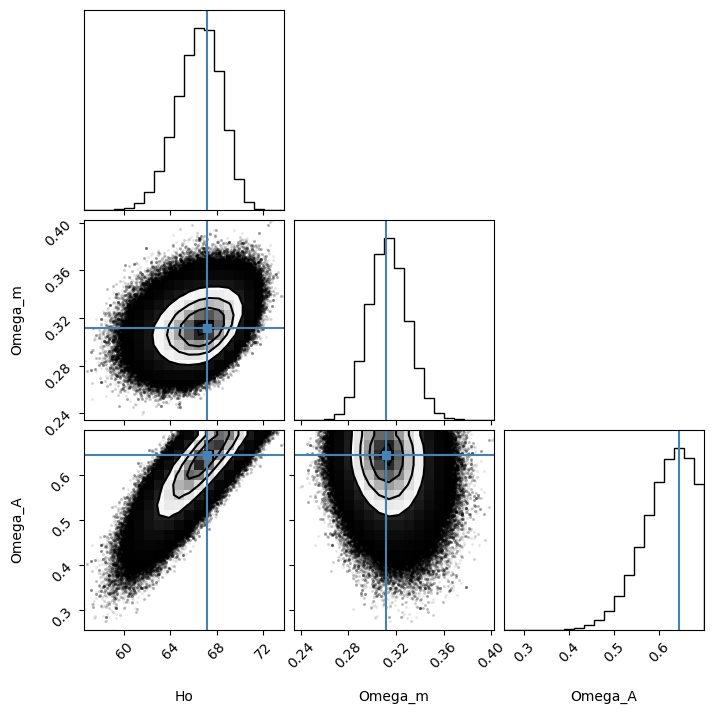

In [44]:
non_flat_samples = sampler.get_chain(flat=True)
print(non_flat_samples.shape)
labels = ["Ho", "Omega_m","Omega_A"]

fig = corner.corner(
    non_flat_samples, labels=labels, truths=[H0_opt_LCDM_flat, Wm0_opt_LCDM_flat,WA0_opt_LCDM_flat]
);

In [45]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(non_flat_samples[:, i], [16, 50, 84]) 
    q= np.diff(mcmc) 
    txt = "\mathrm{{{3}}} = {0:3}_{{-{1:.3f}}}^{{{2:.3f}}}" 
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [46]:
import getdist
from getdist import plots,MCSamples
import matplotlib.pyplot as plt
names = ["Ho","Omega_M","Omega_A"]
labels = ["H_0","\Omega_{M}","Omega_{A}"]
samples2 = MCSamples(samples=non_flat_samples,names = names, labels = labels)
means=samples2.getMeans()
stats=samples2.getMargeStats() 
conf_levels = samples2.contours
print(means)
mcmc

Removed no burn in


[66.42786453  0.31354121  0.61626645]


array([0.56040583, 0.62423418, 0.67283595])

In [47]:
lims1 = stats.parWithName('Ho').limits
lims2 = stats.parWithName('Omega_M').limits 
lims3 = stats.parWithName('Omega_A').limits 
for conf, lim1, lim2, lim3 in zip(samples2.contours,lims1, lims2, lims3):
      if conf != 0.6827:
          continue

      print('value: %.3f, lower: %.3f, upper: %.3f'.format(means[0], lim1.lower - means[0], lim1.upper- means[0]))
      print('value: %.2f, lower: %.2f, upper: %.2f'.format(means[1], lim2.lower - means[1], lim2.upper - means[1]))
      print('value: %.2f, lower: %.2f, upper: %.2f'.format(means[1], lim3.lower - means[1], lim3.upper - means[1]))

<Figure size 600x450 with 0 Axes>

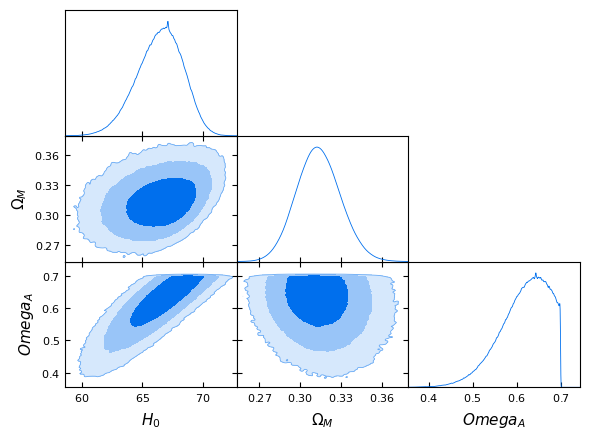

In [48]:
g = plots.get_single_plotter()
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})
g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);